In [2]:
# 1) Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

from functools import partial

In [6]:

from dotenv import load_dotenv

from pathlib import Path

env_path = Path(".env-live")

if env_path.exists():
    load_dotenv(dotenv_path=env_path)

In [8]:
import os
os.environ['JRJ_MODEL_REGISTRY_S3_BUCKET_NAME']


'273-g2'

In [10]:
from jrjModelRegistry.jrjModelRegistry import registerAJrjModel


Pinged your deployment. You successfully connected to MongoDB!


In [11]:
# 2) LOAD DATA
df = pd.read_csv("online_retail_customer_churn_cleaned.csv")
df.head()

,Customer_ID,Age,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Target_Churn,Gender_Female,Gender_Male,Gender_Other,Promotion_Response_Ignored,Promotion_Response_Responded,Promotion_Response_Unsubscribed
0,1,62,45.15,5892.58,5,22,453.80,2,0,3,129,1,1,0.0,0.0,1.0,0.0,1.0,0.0
1,2,65,79.51,9025.47,13,77,22.90,2,2,3,227,0,0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,18,29.19,618.83,13,71,50.53,5,2,2,283,0,1,0.0,1.0,0.0,0.0,1.0,0.0
3,4,21,79.63,9110.30,3,33,411.83,5,3,5,226,1,1,0.0,0.0,1.0,1.0,0.0,0.0
4,5,21,77.66,5390.88,15,43,101.19,3,0,5,242,0,0,0.0,0.0,1.0,0.0,0.0,1.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Customer_ID                      1000 non-null   int64  
 1   Age                              1000 non-null   int64  
 2   Annual_Income                    1000 non-null   float64
 3   Total_Spend                      1000 non-null   float64
 4   Years_as_Customer                1000 non-null   int64  
 5   Num_of_Purchases                 1000 non-null   int64  
 6   Average_Transaction_Amount       1000 non-null   float64
 7   Num_of_Returns                   1000 non-null   int64  
 8   Num_of_Support_Contacts          1000 non-null   int64  
 9   Satisfaction_Score               1000 non-null   int64  
 10  Last_Purchase_Days_Ago           1000 non-null   int64  
 11  Email_Opt_In                     1000 non-null   int64  
 12  Target_Churn         

In [13]:
df.head(5)

,Customer_ID,Age,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Target_Churn,Gender_Female,Gender_Male,Gender_Other,Promotion_Response_Ignored,Promotion_Response_Responded,Promotion_Response_Unsubscribed
0,1,62,45.15,5892.58,5,22,453.80,2,0,3,129,1,1,0.0,0.0,1.0,0.0,1.0,0.0
1,2,65,79.51,9025.47,13,77,22.90,2,2,3,227,0,0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,18,29.19,618.83,13,71,50.53,5,2,2,283,0,1,0.0,1.0,0.0,0.0,1.0,0.0
3,4,21,79.63,9110.30,3,33,411.83,5,3,5,226,1,1,0.0,0.0,1.0,1.0,0.0,0.0
4,5,21,77.66,5390.88,15,43,101.19,3,0,5,242,0,0,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
sample_data = pd.DataFrame({
    'Annual_Income': [60.5],
    'Total_Spend': [8000],
    'Average_Transaction_Amount': [250.0],
    'Last_Purchase_Days_Ago': [30],
    'Num_of_Purchases': [32],
    'Age': [40],
    'Years_as_Customer': [5],
    'Num_of_Returns': [2]
}).to_dict(orient="records")

In [20]:


# 3) Prepare features (X) and target (y) remove useless Customer ID
X = df.drop(columns=['Customer_ID', 'Target_Churn'])
y = df['Target_Churn']

In [22]:
# 4) Split into "Train+Val" and "Test" (80% and 20% ) # Make sure Test set is not seen
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Shapes -> Train+Val:{X_train_val.shape} Test: {X_test.shape}")

Shapes -> Train+Val:(800, 17) Test: (200, 17)


In [24]:
# 5) Further split Train+Val into Train (75% out of 80%) and Val (25% of out 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

print(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Shapes -> Train: (600, 17), Val: (200, 17), Test: (200, 17)


In [26]:
# 6) INITIAL MODEL: “train” Decision Tree with default settings
dt_initial = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_initial.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [28]:
# 7) Evaluate initial model on validation set
y_val_pred_init = dt_initial.predict(X_val)
print("=== Initial Decision Tree (Validation Results) ===")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_init):.3f}")

=== Initial Decision Tree (Validation Results) ===
Accuracy: 0.560


In [30]:
print(classification_report(y_val, y_val_pred_init))

              precision    recall  f1-score   support

           0       0.54      0.53      0.53        95
           1       0.58      0.59      0.58       105

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



In [32]:
# 8) Hyperparameter tuning with GridSearchCV (evaluate Precision, Recall, and F1; refit on F1)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth':        [None, 3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split':[2, 5, 10]
}

scoring = {
    'Precision': 'precision',
    'Recall':    'recall',
    'F1':        'f1'
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit='F1',    # retrain final model on the parameter set that yields the highest F1
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("=== Grid Search Best Parameters (by F1) ===")
print(grid_search.best_params_)
print(f"Best cross-validated F1: {grid_search.best_score_:.3f}")




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 180, in <module>
    exitcode = process_obj._bootstrap()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda

=== Grid Search Best Parameters (by F1) ===
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validated F1: 0.557


In [33]:
# 9) Evaluate the tuned model on the validation set
best_dt = grid_search.best_estimator_
y_val_pred = best_dt.predict(X_val)

from sklearn.metrics import classification_report
print("\n=== Tuned Decision Tree on Validation Set ===")
print(classification_report(y_val, y_val_pred, digits=3))


=== Tuned Decision Tree on Validation Set ===
              precision    recall  f1-score   support

           0      0.578     0.389     0.465        95
           1      0.574     0.743     0.647       105

    accuracy                          0.575       200
   macro avg      0.576     0.566     0.556       200
weighted avg      0.576     0.575     0.561       200



In [34]:
# 10) Feature importance & selection
import numpy as np

importances = best_dt.feature_importances_
threshold   = np.mean(importances)
selected_features = X_train.columns[importances > threshold].tolist()

print("\nSelected features (importance > mean):")
print(selected_features)


Selected features (importance > mean):
['Age', 'Total_Spend', 'Years_as_Customer', 'Num_of_Purchases', 'Average_Transaction_Amount', 'Last_Purchase_Days_Ago']


In [38]:
# 11) Retrain and evaluate on selected features
dt_final = DecisionTreeClassifier(
    **grid_search.best_params_,
    class_weight='balanced',
    random_state=42
)
dt_final.fit(X_train[selected_features], y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                       min_samples_split=5, random_state=42)

In [40]:
# Validation set performance
y_val_final = dt_final.predict(X_val[selected_features])
print("\n=== Final Decision Tree (Selected Features) on Validation Set ===")
print(classification_report(y_val, y_val_final, digits=3))


=== Final Decision Tree (Selected Features) on Validation Set ===
              precision    recall  f1-score   support

           0      0.571     0.337     0.424        95
           1      0.562     0.771     0.651       105

    accuracy                          0.565       200
   macro avg      0.567     0.554     0.537       200
weighted avg      0.567     0.565     0.543       200



In [42]:
# 12)

# Test set performance
y_test_final = dt_final.predict(X_test[selected_features])
print("\n=== Final Decision Tree (Selected Features) on Test Set ===")
print(classification_report(y_test, y_test_final, digits=3))


=== Final Decision Tree (Selected Features) on Test Set ===
              precision    recall  f1-score   support

           0      0.429     0.189     0.263        95
           1      0.513     0.771     0.616       105

    accuracy                          0.495       200
   macro avg      0.471     0.480     0.439       200
weighted avg      0.473     0.495     0.448       200



# Conclusion
｜
Comparing our un-tuned (Model 1) and tuned (Model 2) decision-tree churn predictors reveals a clear trade-off. After hyperparameter tuning, recall jumps from 59 % to 77 %, meaning we now flag 77 out of every 100 true churners—up from 59—allowing us to more aggressively intercept at-risk customers. However, this gain comes at the expense of precision, which falls from 58 % to 51 %, so roughly half of our “at risk” alerts become false positives. Overall accuracy dips slightly (56 % → 49.5 %), underscoring that a single tuned tree trades off overall correctness for richer churn coverage.

To deploy effectively, the business must balance:

Maximizing catch-rate (high recall) to protect revenue,

Minimizing wasted touches (high precision) to control marketing spend.


# Key Insights


High Churn Recall (77%)
We successfully flag 77 out of every 100 true churners.
Recommendation: Leverage low-cost automated channels (email/SMS) for initial outreach to avoid overspending on false positives.
Moderate Churn Precision (51%)
Only half of those predicted to churn actually do, meaning roughly 49% of “at-risk” alerts are false alarms.
Recommendation: If outreach costs are substantial, raise the classification threshold to improve precision—even if it means missing some churners.
Poor Loyalty Detection (19% Recall for Non-Churners)
We correctly identify only 19% of loyal customers, causing 81% to receive unnecessary retention offers.
Recommendation: Introduce a secondary filter or adjust class weights to reduce “loyal customer fatigue” and protect goodwill.
Top Predictive Features
Recency & Frequency: Last_Purchase_Days_Ago, Num_of_Purchases, Average_Transaction_Amount
Monetary Value: Total_Spend
Demographics & Tenure: Age, Years_as_Customer
Action: Monitor these signals in real time and trigger automated micro-campaigns when recency or frequency drops below set thresholds.
Next-Step Improvements
Model Enhancements: Test ensemble methods (Random Forest, XGBoost) for higher overall accuracy and reduced false positives.
Feature Enrichment: Incorporate website behavior, customer support sentiment, and promotion engagement for deeper customer insights.
Threshold Tuning: Systematically explore decision thresholds to find the optimal balance of precision vs. recall for both classes.


In [46]:
print(selected_features)

['Age', 'Total_Spend', 'Years_as_Customer', 'Num_of_Purchases', 'Average_Transaction_Amount', 'Last_Purchase_Days_Ago']


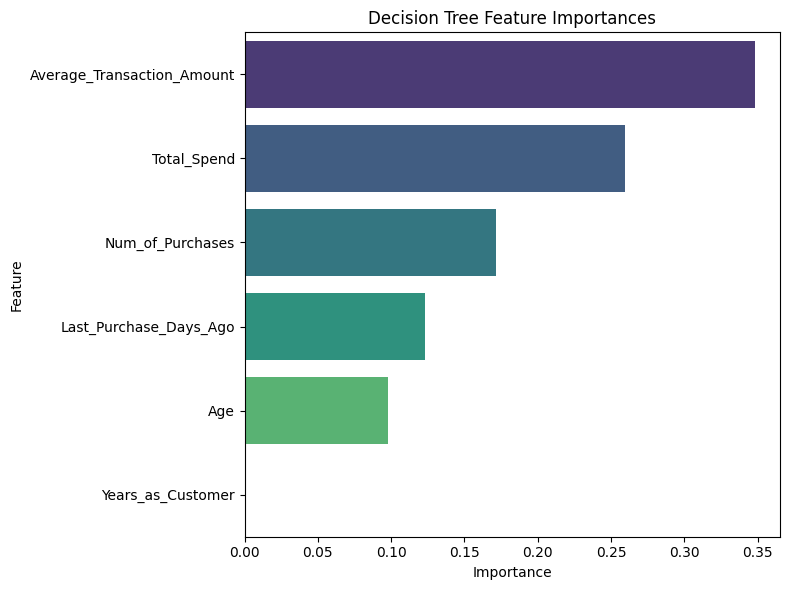

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#graphic
importances = dt_final.feature_importances_


feat_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='viridis')

plt.title('Decision Tree Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()


In [50]:
from functools import partial

In [54]:
def churnModelTransformer(dataForTransfer):
    import pandas as pd
    import statsmodels.api as sm
    
    if isinstance(dataForTransfer, pd.DataFrame):
        df = dataForTransfer.copy()
    else:
        df = pd.DataFrame(dataForTransfer)

    dfTransformer = sm.add_constant(df[selected_features])
    return dfTransformer

In [57]:
# 2) predictor: 先跑 transformer，再调用决策树的 predict
def decisionTreePredictor(model, raw_data):
    return model.predict(raw_data).tolist()

In [60]:
dt_final.transformer= churnModelTransformer

In [62]:
dt_final.mainPredictor  = partial(decisionTreePredictor, dt_final)

In [64]:
dt_final.mainPredictor(dt_final.transformer(sample_data))

[1]

In [68]:
from sklearn.metrics import classification_report

dt_metadata = {
  "modelName":        "Group2_customerChurn_DTModel",
  "version":          "1.0.9",
  "params":           dt_final.get_params(),
  "score":            float(dt_final.score(X_test[selected_features], y_test)),
  "modelLibrary":     "sklearn.tree.DecisionTreeClassifier",
  "libraryMetadata": {
    "feature_importances":   dt_final.feature_importances_.tolist(),
    "n_features":            int(dt_final.n_features_in_),
    "n_classes":             int(dt_final.n_classes_),
    "classes":               dt_final.classes_.tolist(),
    "classification_report": classification_report(
                                y_test,
                                dt_final.predict(X_test[selected_features])
                              )
  },
  "sampleData": {
    "dataForTransfer": X_test[selected_features].head(5).to_dict(orient='records')
  }
}


In [70]:
registerAJrjModel(dt_final, dt_metadata)

✅ Uploaded encrypted ZIP to s3://273-g2/Group2_customerChurn_DTModel__1.0.9.pkl.zip


{'_id': '685e5775c6bb625049d2afee',
 'modelName': 'Group2_customerChurn_DTModel',
 'version': '1.0.9',
 'params': {'ccp_alpha': 0.0,
  'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'monotonic_cst': None,
  'random_state': 42,
  'splitter': 'best'},
 'score': 0.495,
 'modelLibrary': 'sklearn.tree.DecisionTreeClassifier',
 'libraryMetadata': {'feature_importances': [0.09772003131448968,
   0.25924674438810047,
   0.0,
   0.17169866184513244,
   0.3479471479765291,
   0.12338741447574833],
  'n_features': 6,
  'n_classes': 2,
  'classes': [0, 1],
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.43      0.19      0.26        95\n           1       0.51      0.77      0.62       105\n\n    accuracy                           0.49       200\n   ma